# Домашнее задание 7

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 7 апреля. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_7

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим 'распределенную' задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{n} \sum\limits_{i=1}^n f_i(x) = \frac{1}{2n} \sum\limits_{i=1}^n x^T A_i x - b^T_i x,
\end{equation}
где $n = 10$, в качестве матриц $\{A_i\}_{i=1}^n$ - случайные матрицы с $L =1000$, $\mu = 1$, $d = 100$, $\{b_i\}_{i=1}^n$ - так же случайные векторы.

__(а)__ Для такой задачи симулируем распределенное решение (вычисления на 1 компьютере, без распараллеливания). 
Реализуйте обычный распределенный градиентый спуск с операторами сжатия. Сжимайте информацию только от устройств к серверу. Используйте операторы сжатия $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Для каждого случая подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число 'переданной информации' от устройств к серверу). Сделайте вывод.

In [63]:
import my_optimization as opt
import numpy as np

In [64]:
#generating the problem setting
args = {}
args['n_workers'] = 10
args['L'] = 1000
args['mu'] = 1
args['d'] = 100
args['seed'] = 40

args['n'] = 1 #not to have a mistake in saga

np.random.seed(args['seed'])
args['A_list'] = [opt.gen_A(args['d'], args['mu'] , args['L']) for i in range(args['n_workers'])]
args['b_list'] = [np.random.rand(args['d']) for i in range(args['n_workers'])]
x_0    = np.random.random_sample(args['d'])

def d_f_quad(x, args):
    res = 0
    for i in range(args['n_workers']):
        res += 1./2 * x.T @ args['A_list'][i] @ x - args['b'][i] @ x
    return res / (2 * args['n_workers'])

def d_f_quad_grad(x, args):
    grad_list = []
    for i in range(args['n_workers']):
         grad_list.append(args['A_list'][i] @ x - args['b_list'][i])
    return grad_list

In [65]:
FLOAT_BYTES = 4

def best_compressor_alg(title, n_iter, compression_coeff, c_param_list, y_lim = 1e-2, rand_k_activate = False, 
                        top_k_activate = False, diana_activate = False, ef_activate = False):

    def check_gamma(k, f, grad_f, x_k, x_true, args):
            return args['c']/(4 * args['L'])

    k_param = int(args['d'] * compression_coeff)

    x, y, labels = [], [], []
    def best_gamma(k, f, grad_f, x_k, x_true, args):
        return c_param_list[0]/(4 * args['L'])

    best_alg = opt.GradientOptimizer(
                                    d_f_quad, d_f_quad_grad, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = best_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate
                                    )
    best_points_arr, best_differences_arr, best_times_arr, best_acc_arr = best_alg.descent()
    best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]

    idx, best_idx = 0, 0
    for args['c'] in c_param_list:    
        check_alg = opt.GradientOptimizer(
                                    d_f_quad, d_f_quad_grad, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = check_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate
                                    )
        points_arr, differences_arr, times_arr, acc_arr = check_alg.descent()

        if (len(differences_arr) < len(best_differences_arr)): 
            best_alg = check_alg
            best_differences_arr = differences_arr
            best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
            best_idx = idx
            best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
        else:
             if differences_arr[-1] < best_differences_arr[-1]:
                best_alg = check_alg
                best_differences_arr = differences_arr
                best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
                best_idx = idx
                best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))

        information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(differences_arr))]
        x.append(information)
        y.append(differences_arr)
        labels.append(title + r"-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
        idx += 1

    best_idx_list = [best_idx]         
    return x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx_list

In [66]:
#for the b)
X_compare, Y_compare, Labels_compare = [], [], []

100%|██████████| 1000/1000 [00:00<00:00, 1578.13it/s]


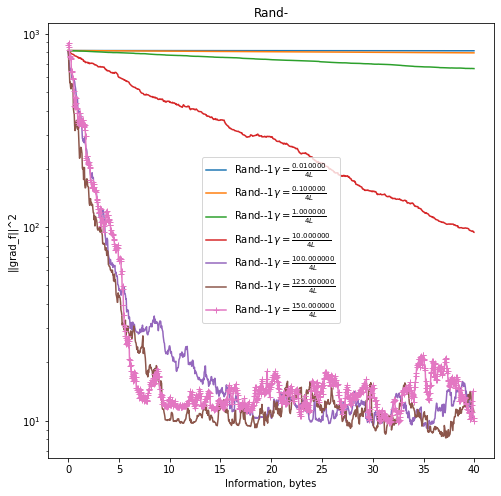

In [67]:
#LR fitting Rand1%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.01
c_param_list =  [0.01, 0.1, 1, 10, 100, 125, 150]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [68]:
X_compare.append(x[4])
Y_compare.append(y[4])
Labels_compare.append(labels[4])

### LR choice for Rand1%
- The function said that the best is when $c = 125$ (see the choice criteria 1), but I think the best is $c = 100$ because of stability

100%|██████████| 1000/1000 [00:00<00:00, 1466.09it/s]


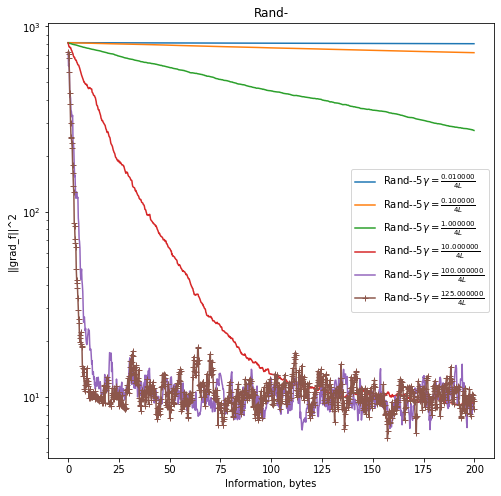

In [69]:
#LR fitting Rand5%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.05
c_param_list =  [0.01, 0.1, 1, 10, 100, 125]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title, 
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [70]:
X_compare.append(x[4])
Y_compare.append(y[4])
Labels_compare.append(labels[4])

### LR choice for Rand5%
- The function said that the best is when $c = 125$ (see the choice criteria 1), but I personally think the best is $c = 100$ because because it is fastest to converge

100%|██████████| 1000/1000 [00:00<00:00, 1328.25it/s]


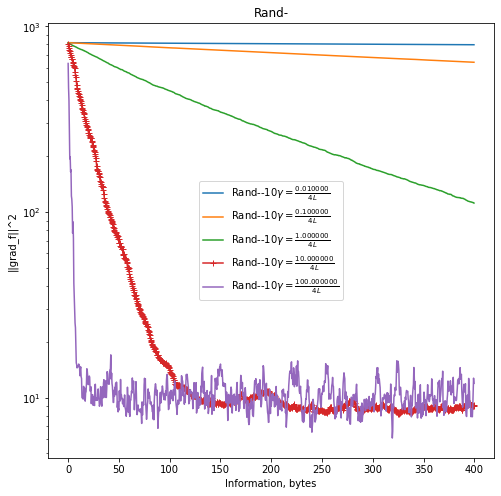

In [71]:
#LR fitting Rand10%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.1
c_param_list =  [0.01, 0.1, 1, 10, 100]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [72]:
X_compare.append(x[3])
Y_compare.append(y[3])
Labels_compare.append(labels[3])

### LR choice for Rand10%
- The function said that the best is when $c = 100$ (see the choice criteria 1), but I personally think the best is $c = 10$ because because it is stable than others, although not the fastest

100%|██████████| 1000/1000 [00:00<00:00, 1330.25it/s]


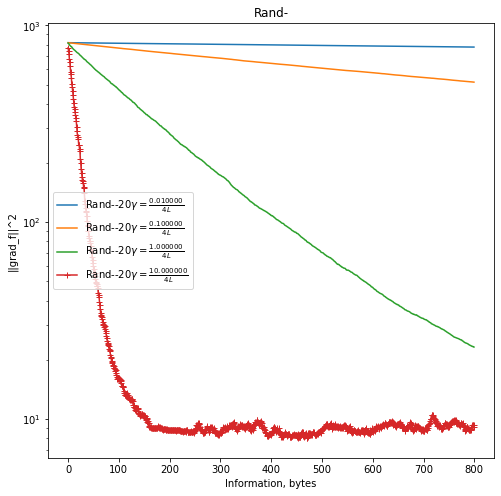

In [73]:
#LR fitting Rand20%
title = "Rand-"
n_iter = 1000
compression_coeff = 0.2
c_param_list = [0.01, 0.1, 1, 10]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e0, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [74]:
X_compare.append(x[3])
Y_compare.append(y[3])
Labels_compare.append(labels[3])

### LR choice for Rand20%
- The function said that the best is when $c = 10$ (see the choice criteria 1) and I agree

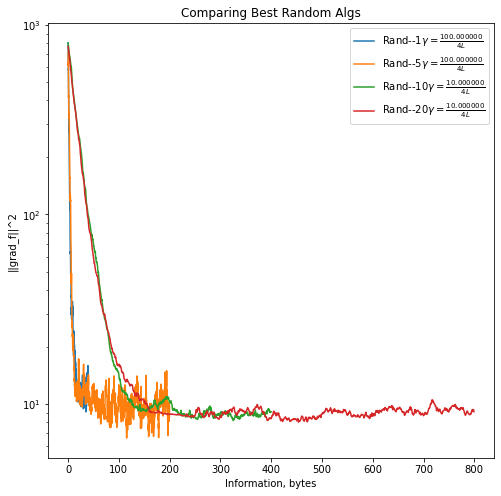

In [75]:
#Comparing them together
opt.plot_graphs(X_compare, Y_compare, x_label = "Information, bytes", lines_labels = Labels_compare, title = "Comparing Best Random Algs", logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = [])

### Conclusion
With the current theoretical learning rate the best result in terms of the speed and depth of convergence achieves Rand-5%, actually I don't have a clue why

The following statement I had for Rand-10%: it may be the best probably because the case is more independent (we have $d = 100, n = 10, k = 10$, so we choose the same coordinates less possibly and the overall coverage is pretty good)

__(б)__ Теперь будем использовать в качестве операторов сжатия $\text{Top}10\%$. Сжимайте информацию только от устройств к серверу. Используйте два метода: обычный распределенный градиентный спуск с операторами сжатия, также распределенный градиентный спуск с техникой компесации ошибки (error feedback - смотри Алгоритм 1 из [статьи](https://arxiv.org/abs/2002.12410)). Для каждого метода подберите шаг $\gamma$ для наилучшей сходимости, постройте сравнительный график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [76]:
X_compare, Y_compare, Labels_compare = [], [], []

100%|██████████| 2000/2000 [00:00<00:00, 2431.71it/s]


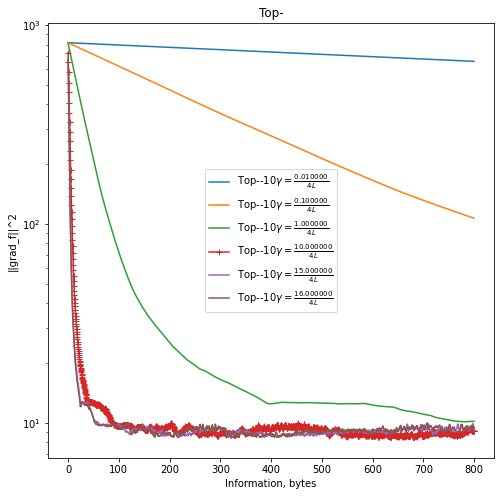

In [77]:
#LR fitting Top10%
title = "Top-"
n_iter = 2000
compression_coeff = 0.1
c_param_list = [0.01, 0.1, 1, 10, 15, 16] #16+ - divergence
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [78]:
X_compare.append(x[4])
Y_compare.append(y[4])
Labels_compare.append(labels[4])

### LR choice for Top10%
- The function said that the best is when $c = 15$ (see the choice criteria 1) and I agree with this statement

100%|██████████| 1000/1000 [00:00<00:00, 1936.16it/s]


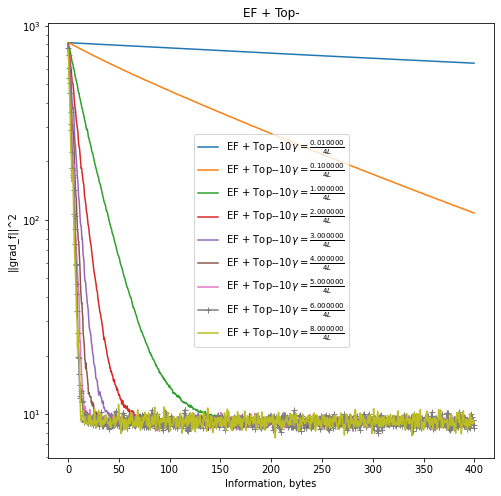

In [79]:
#LR fitting Top10%
title = "EF + Top-"
n_iter = 1000
compression_coeff = 0.1
c_param_list = [0.01, 0.1, 1, 2, 3, 4, 5, 6, 8] 
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx = best_compressor_alg(title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

In [80]:
X_compare.append(x[6])
Y_compare.append(y[6])
Labels_compare.append(labels[6])

### LR choice for Top10% + EF
- The function said that the best is when $c = 5$ (see the choice criteria 1) and I agree with this statement (but based on the plot $c = 6$ also fits)

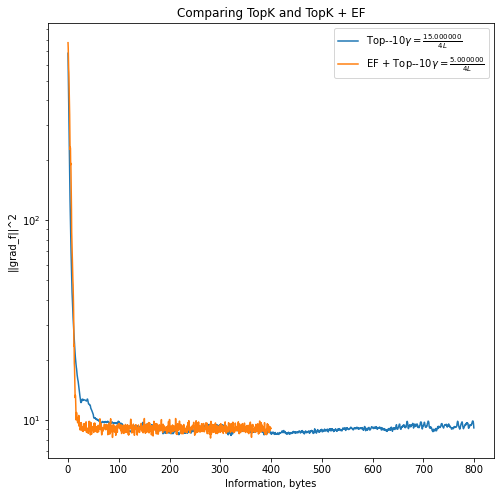

In [81]:
#Comparing them together
opt.plot_graphs(X_compare, Y_compare, x_label = "Information, bytes", lines_labels = Labels_compare, title = "Comparing TopK and TopK + EF", logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = [])

### Conclusion

So, the best error feedback mechanism helps to converge faster (and helps to basically converge)

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Симмулируем распределенное решение. Для этого разделите обучающую выборку случайно и равномерно на $n=10$ частей. Каждая такая часть сформирует $f_i$.

In [82]:
#Data Preprocessing
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np

dataset = "mushrooms.txt"

data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = y * 2 - 3

args = {}
args['n'], args['d'] = X.shape[0], X.shape[1] 
args['n_workers'] = 10

args['X_train'], args['X_test'], args['y_train'], args['y_test'] = train_test_split(X, y, test_size=0.2, random_state=True)
x_0 = np.zeros(args['d'])
args['L'] = np.max(np.linalg.eigvals(1/(4*len(args['X_train'])) * args['X_train'].T @ args['X_train']))

def split_dataset(X_train, y_train, n):
    data = np.column_stack((X_train, y_train))
    np.random.shuffle(data)
    parts = np.array_split(data, n)
    X_parts = [part[:,:-1] for part in parts]
    y_parts = [part[:,-1].astype(int) for part in parts]
    return X_parts, y_parts

args['X_train_list'], args['y_train_list'] = split_dataset(args['X_train'], args['y_train'], args['n_workers'])

In [83]:
def d_logloss_mushrooms(w, args):
    ans = 0
    for i in range(len(args['X_train'])):
        ans += np.log(1 + np.exp(-(w @ args["X_train"][i]) * args["y_train"][i]))
    return ans / len(args["X_train"])

def d_logloss_grad_mushrooms (w, args):
    grad_list = []
    for j in range(args['n_workers']):
        n_samples = len(args['X_train_list'][j]) 
        
        grad_j = np.zeros(w.size) 

        for i in range(n_samples):
            grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
        grad_j /= n_samples
        grad_list.append(grad_j)
        
    return grad_list

__(б)__ Реализуйте симмуляцию (как в Задаче 1) обычного распределенного градиентного спуска с операторами сжатия, распределенного градиентного спуска с техникой error feedback, алгоритма DIANA (смотри Алгоритм 11 из [статьи](https://arxiv.org/abs/1905.11261)). Сжатия происходят только при пересылке от сервера к устройствам.

__(в)__ Используйте операторы сжатия $\text{Top}10\%$ и $\text{Rand}10\%$ во всех трех методах (всего получается 6 разных подходов). Для каждого подхода подберите шаг $\gamma$ для наилучшей сходимости, постройте 2 сравнительных графика сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$ или точность предсказаний, а по оси $x$ - число итераций/коммуникаций). Сделайте вывод.

In [84]:
X_crit, Y_crit, Labels_crit = [], [], []
X_acc, Y_acc, Labels_acc = [], [], []
specific_slice_num = 0

In [85]:
FLOAT_BYTES = 4

def best_compressor_alg_loss(loss, loss_gradient, func_title, n_iter, compression_coeff, c_param_list, y_lim = 1e-2, rand_k_activate = False, 
                        top_k_activate = False, diana_activate = False, ef_activate = False, ef21_activate = False, marina_activate = False, p_marina = 0.5):
    
    def log_acc(k, f, grad_f, x_k, x_true, args):
        corr_count = 0
        test_count = len(args['y_test'])
        for i in range(test_count):
            if args['X_test'][i].dot(x_k) * args['y_test'][i] > 0:
                corr_count += 1
        return corr_count / test_count

    def check_gamma(k, f, grad_f, x_k, x_true, args):
            return args['c']/(4 * args['L'])

    k_param = int(args['d'] * compression_coeff)

    x, y, labels, accs = [], [], [], []
    def best_gamma(k, f, grad_f, x_k, x_true, args):
        return c_param_list[0]/(4 * args['L'])

    best_alg = opt.GradientOptimizer(
                                    loss, loss_gradient, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = best_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate, acc_k = log_acc, 
                                    ef21_activate=ef21_activate, marina_activate=marina_activate, p_marina=p_marina
                                    )
    best_points_arr, best_differences_arr, best_times_arr, best_acc_arr = best_alg.descent()
    best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
    best_label = 'No best alg yet'
    idx, best_idx = 0, 0
    for args['c'] in c_param_list:    
        check_alg = opt.GradientOptimizer(
                                    loss, loss_gradient, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = check_gamma, n_workers = args['n_workers'],
                                    rand_k_activate = rand_k_activate, top_k_activate=top_k_activate,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = y_lim, diana_activate=diana_activate, ef_activate=ef_activate, acc_k = log_acc, 
                                    ef21_activate=ef21_activate, marina_activate=marina_activate, p_marina=p_marina
                                    )
                                    
        points_arr, differences_arr, times_arr, acc_arr = check_alg.descent()

        if (len(differences_arr) < len(best_differences_arr)): 
            best_alg = check_alg
            best_differences_arr = differences_arr
            best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
            best_idx = idx
            best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
            best_acc_arr = acc_arr
        else:
             if differences_arr[-1] < best_differences_arr[-1]:
                best_alg = check_alg
                best_differences_arr = differences_arr
                best_information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(best_differences_arr))]
                best_idx = idx
                best_label = (title + r"Compressor-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
                best_acc_arr = acc_arr

        information = [compression_coeff * FLOAT_BYTES * _ for _ in range(len(differences_arr))]
        x.append(information)
        y.append(differences_arr)
        labels.append(title + r"-$%i \gamma = \frac{%f}{4L}$" % (k_param, args['c']))
        accs.append(acc_arr)
        idx += 1

    best_idx_list = [best_idx]         
    return x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx_list, accs, best_points_arr

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


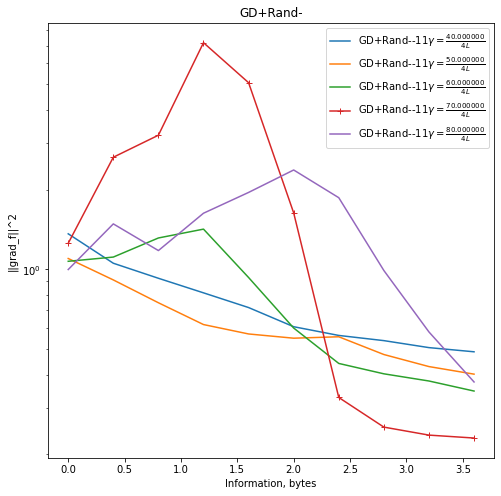

In [86]:
#LR fitting GD + Rand10%
title = "GD+Rand-"
n_iter = 10
compression_coeff = 0.1
c_param_list = [40, 50, 60, 70, 80]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

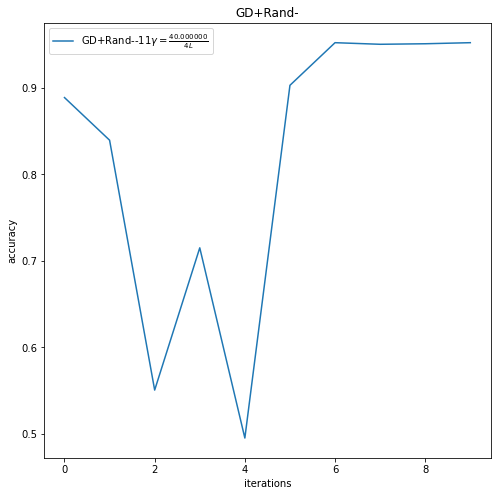

In [87]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Rand10%
- The function said that the best is when $c = 10$ works okay (in the picture there is $c = 0.001$ but I can't change it now because it requires some time)

  3%|▎         | 3/100 [00:01<00:34,  2.85it/s]<ipython-input-83-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in true_divide
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][

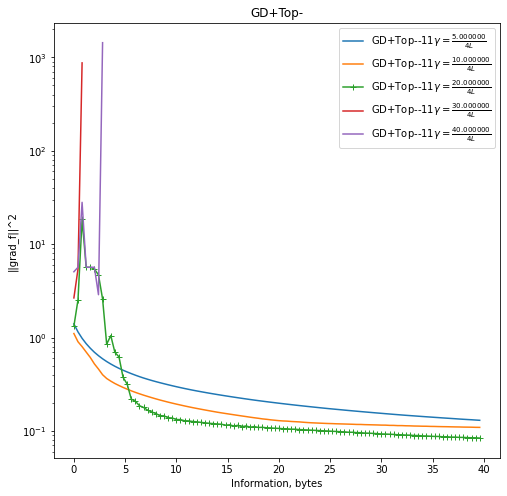

In [88]:
#LR fitting GD + Top-10%
title = "GD+Top-"
n_iter = 100
compression_coeff = 0.1
c_param_list = [5, 10, 20, 30, 40]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

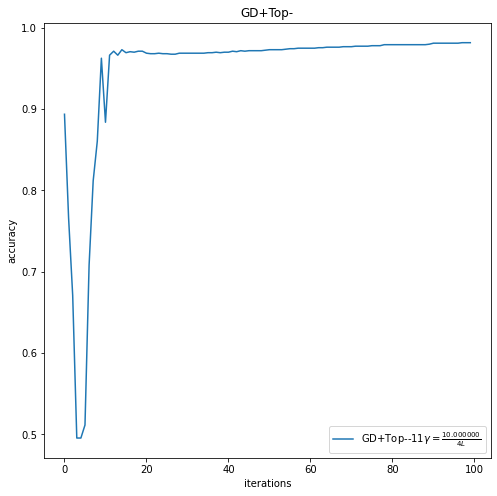

In [89]:
best_idx = best_idx[0] #1

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Top10%
- The function said that the best is when $c = 10$ and I think it's okay

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\HP\Desktop\МФТИ\S6\Optimization S2\HW\Kirill-Acharya-MIPT\my_optimization.py:326: ComplexWarning: Casting complex values to real discards the imaginary part
  compressed_grad[rand_indices] = grad[rand_indices]
c:\Users\HP\Desktop\МФТИ\S6\Optimization S2\HW\Kirill-Acharya-MIPT\my_optimization.py:617: ComplexWarning: Casting complex values to real discards the imaginary part
  errors_list[i] = errors_list[i] + gamma * grad_list[i] - displaced_grad_list[i]
100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


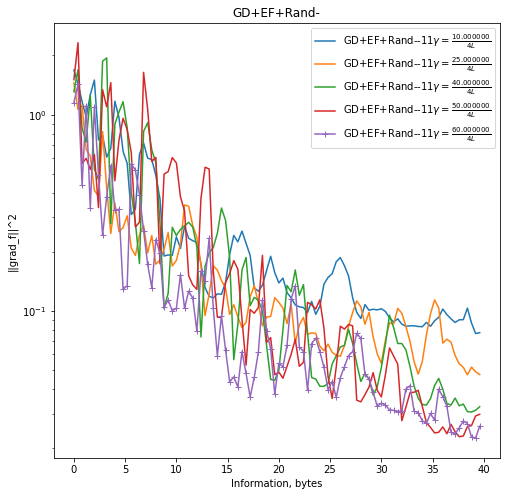

In [90]:
#LR fitting GD + Rand-10% + EF
title = "GD+EF+Rand-"
n_iter = 100
compression_coeff = 0.1
c_param_list = [10, 25, 40, 50, 60]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = False, 
                                            ef_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

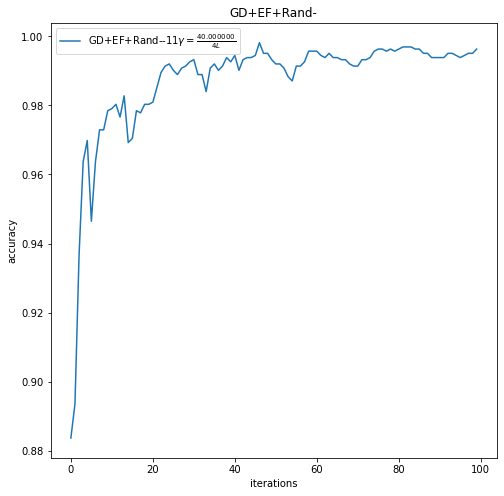

In [91]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Rand10% + EF
- Here I agree with the function again ($c = 50$), although the descent is not smooth

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\HP\Desktop\МФТИ\S6\Optimization S2\HW\Kirill-Acharya-MIPT\my_optimization.py:312: ComplexWarning: Casting complex values to real discards the imaginary part
  compressed_grad[top_indices] = grad[top_indices]
  4%|▍         | 4/100 [00:01<00:25,  3.71it/s]<ipython-input-83-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid v

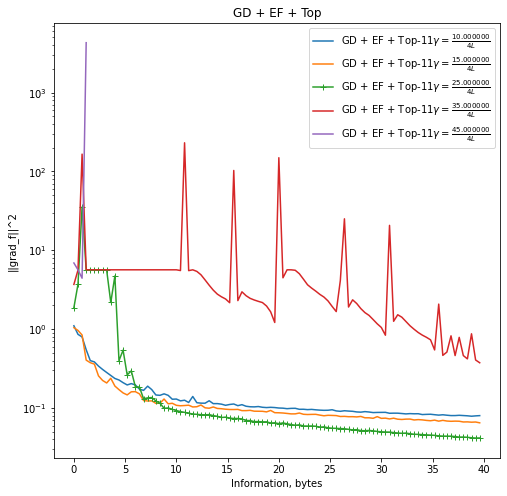

In [92]:
#LR fitting GD + Top-10% + EF
title = "GD + EF + Top"
n_iter = 100
compression_coeff = 0.1
c_param_list = [10, 15, 25, 35, 45]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

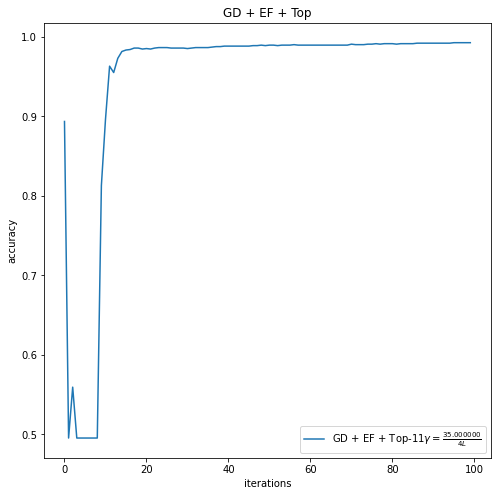

In [93]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for GD + Top10 + EF%
- The function said that the best is when $c = 10$ (see the choice criteria 1) and I agree with this statement

100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


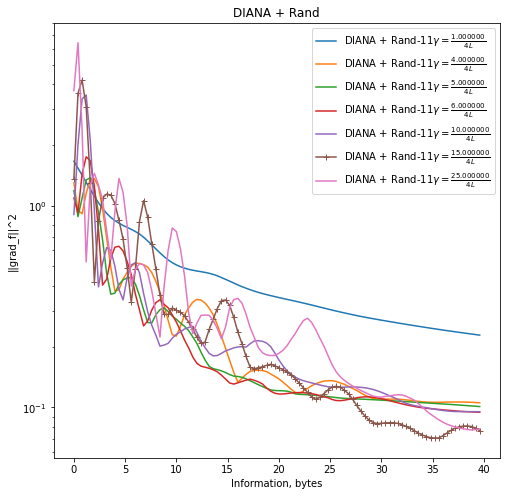

In [94]:
#LR fitting DIANA + Rand10%
title = "DIANA + Rand"
n_iter = 100
compression_coeff = 0.1
c_param_list = [1, 4, 5, 6, 10, 15, 25]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, diana_activate = True, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

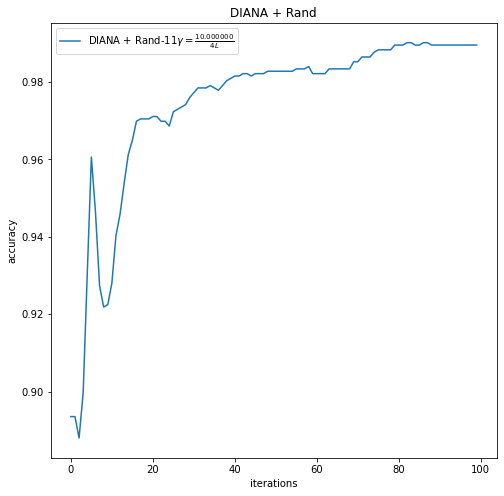

In [95]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for DIANA + Rand10%
- The function said that the best is when $c = 10$ (see the choice criteria 1) but I'll probably choose something between $c = 1$ and $c = 10$, because it is a bit unstable at the start, although it is more stable at the end

  4%|▍         | 4/100 [00:01<00:41,  2.29it/s]<ipython-input-83-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in true_divide
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][

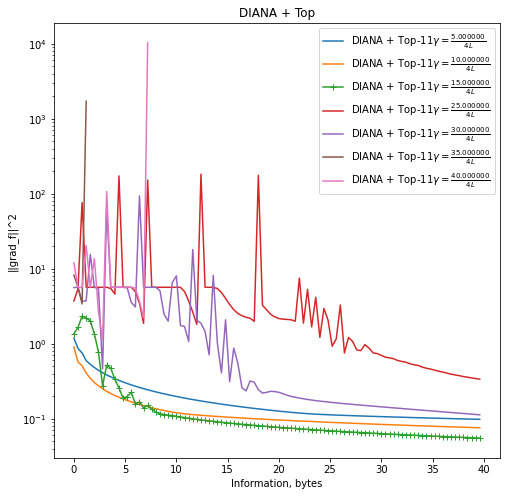

In [96]:
#LR fitting DIANA + Top10%
title = "DIANA + Top"
n_iter = 100
compression_coeff = 0.1
c_param_list = [5, 10, 15, 25, 30, 35, 40]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = True, 
                                            ef_activate = False
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

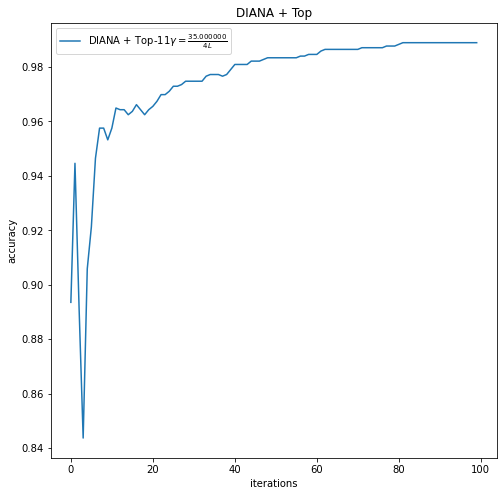

In [97]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = labels, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

### LR choice for DIANA + Top10%
- The function said that the best is when $c = 10$ is the best here

### Comparison in terms of Criterium and Accuracy

I forgot to change the namings but we still have the order they came in

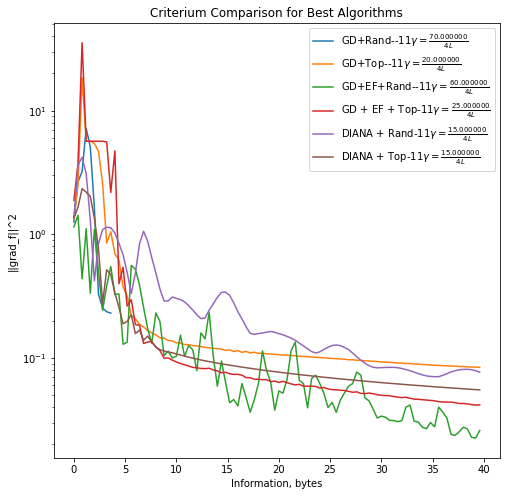

In [98]:
opt.plot_graphs(X_crit, Y_crit, x_label = "Information, bytes", lines_labels = Labels_crit, 
                title = "Criterium Comparison for Best Algorithms", logscale = True, criteria_type = "||grad_f||^2")

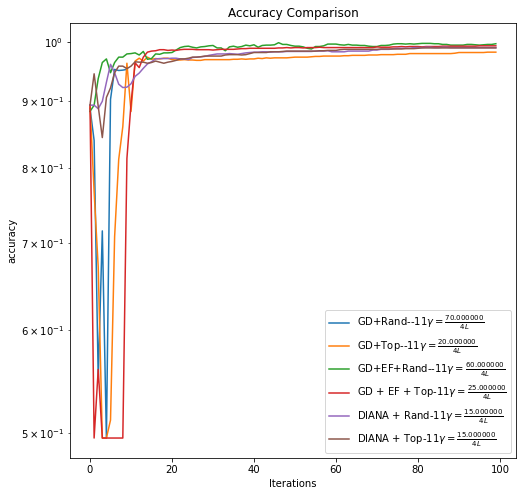

In [99]:
opt.plot_graphs(X_acc, Y_acc, x_label = "Iterations", lines_labels = Labels_acc, title = "Accuracy Comparison", 
                logscale = True, criteria_type = "accuracy")

### Conclusion

Basically we see that greedy approaches with error feedback have a better results than without it, although not everywhere greedy approaches win, for example here we see that random approach show the best result (with the catch on learning rate tuning)

__Бонусные пункты__

__(г)__ Реализуйте два метода: [EF21](https://proceedings.neurips.cc/paper/2021/hash/231141b34c82aa95e48810a9d1b33a79-Abstract.html) и [MARINA](https://arxiv.org/abs/2102.07845). Добавьте их к сравнительному анализу из пункта (в) (здесь важно обратить внимание на особенности алгоритма MARINA и отразить это в анализе). Сделайте вывод. 

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


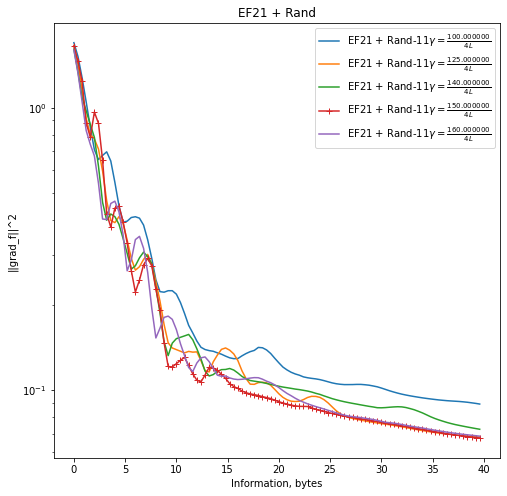

In [100]:
#LR fitting EF21 + Rand10%
title = "EF21 + Rand"
n_iter = 100
compression_coeff = 0.1
c_param_list = [100, 125, 140, 150, 160]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, ef21_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

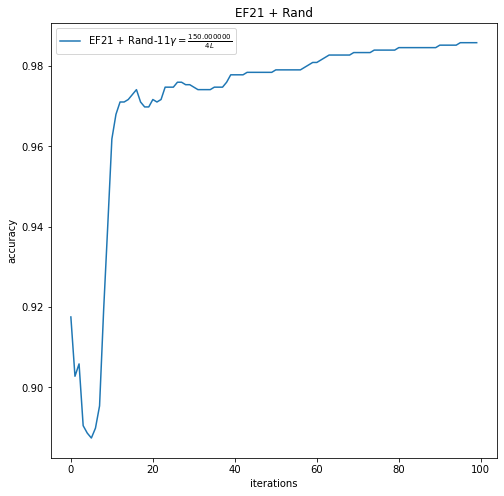

In [104]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = Labels_acc, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


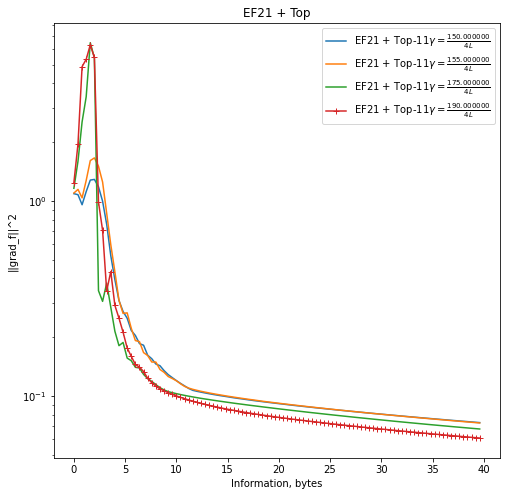

In [ ]:
#LR fitting EF21 + Top10%
title = "EF21 + Top"
n_iter = 100
compression_coeff = 0.1
c_param_list = [150, 155, 175, 190, 225]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, diana_activate = False, 
                                            ef_activate = False, ef21_activate = True
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

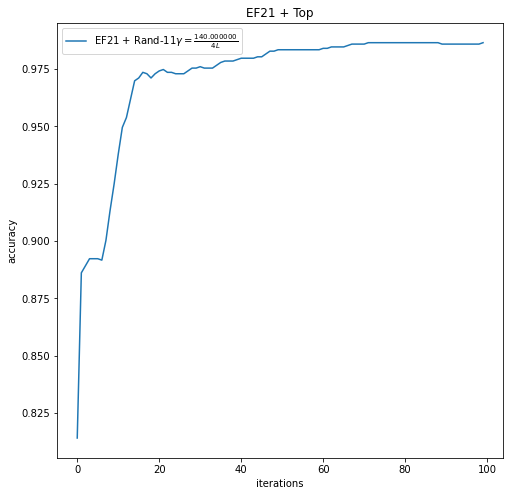

In [ ]:
best_idx = best_idx

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = Labels_acc, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

In [ ]:
#LR fitting Marina + Rand10%%
title = "Marina + Rand"
n_iter = 100
compression_coeff = 0.1
c_param_list = [1, 4, 8]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = True, top_k_activate = False, marina_activate = True,
                                            )

100%|██████████| 100/100 [09:36<00:00,  5.77s/it]


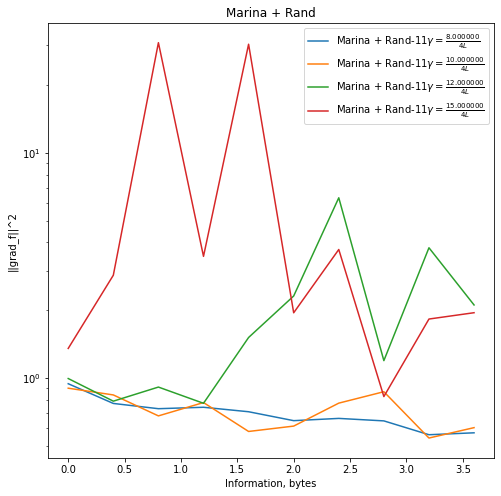

In [ ]:
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx, specific_slice=[0, 1, 2, 3])

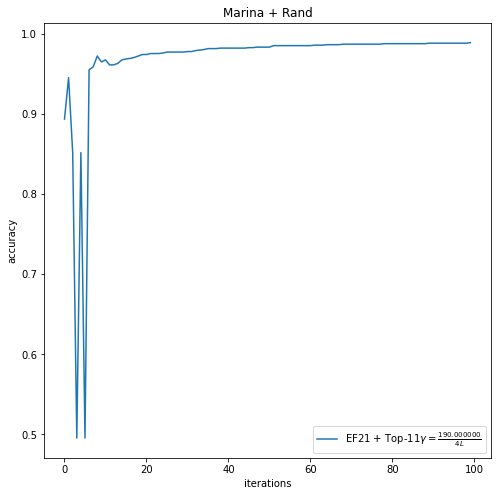

In [ ]:
best_idx = best_idx[0]

X_acc.append([i for i in range(n_iter)])
Y_acc.append(accs[best_idx])
Labels_acc.append(labels[best_idx])
opt.plot_graphs(X_acc, Y_acc, x_label = "iterations", lines_labels = Labels_acc, 
                title = title, logscale = False, criteria_type = "accuracy", specific_slice=[specific_slice_num])

X_crit.append(x[best_idx]) 
Y_crit.append(y[best_idx]) 
Labels_crit.append(labels[best_idx]) 

specific_slice_num += 1

 30%|███       | 3/10 [00:21<00:50,  7.14s/it]<ipython-input-83-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in true_divide
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j

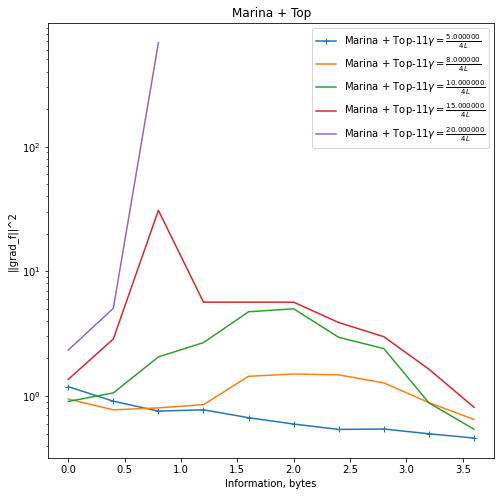

In [105]:
#LR fitting Marina + Top10%%
title = "Marina + Top"
n_iter = 10
compression_coeff = 0.1
c_param_list = [5, 8, 10, 15, 20]
x, y, labels, best_alg, best_information, best_differences_arr, best_label, best_idx, accs, best_points_arr = best_compressor_alg_loss(
                                            d_logloss_mushrooms, d_logloss_grad_mushrooms, title,
                                            n_iter, compression_coeff, c_param_list, y_lim = 1e-2, 
                                            rand_k_activate = False, top_k_activate = True, marina_activate = True, p_marina=0.9
                                            )
opt.plot_graphs(x, y, x_label = "Information, bytes", lines_labels = labels, title = title, logscale = True, criteria_type = "||grad_f||^2", idx_marker_arr = best_idx)

__(д)__ Добавьте в лучшие 3 (на Ваш взгляд) метода (обычный GD с оператором сжатия, GD с EF, DIANA, EF21, MARINA) возможность сжимать и при передаче от сервера к устройству. Для сжатия используйте только $\text{Top}10\%$ и $\text{Rand}10\%$. Проведите серию экспериментов и ответьте на следующие пункты:

1) Если при сжатии на сервере используются $\text{Top}10\%$ нужно ли использовать технику компесации ошибки на сервере? Опишите, как добавляли еe в метод (лучший вариант - выписать алгоритм частично или целиком). 

2) Перебирая разные комбинации из операторов $\text{Top}10\%$ и $\text{Rand}10\%$ для сжатия на сервера и на устройствах, найдите лучшую конфигурацию операторов сжатия для каждого метода.

3) Какой метод и с каким операторами показал в итоге лучшие результаты? Использовался ли при этом дополнительный error feedback на сервере? 

Here I'll keep these methods: GD + TopK + EF, GD + TopK + EF21, DIANA 

1. The Error Feedback on the server (Insiped by [Alg. 1](https://arxiv.org/pdf/2002.12410.pdf))

Let's think of that in terms of one step:

Workers send the compressed gradients to the Master node: $g^{c}_i$

Master computes the "true" (compressed only by workers) gradient: $g = \frac1n \Sigma_{i = 1}^n g^{c}_i$

Then it compresses the result using the error on the Master node: $g^c = C(e + \gamma g)$

Master node updates its error: $e = e + \gamma g - g^c$

Master performs update $x = x - g^c$ and sends $x$ to all workers

The realization is in the function `descent` of the `GradientOptimizer` class

Now let's do task 2 to see how does the server EF affects on the overall performance

In [112]:
def log_acc(k, f, grad_f, x_k, x_true, args):
        corr_count = 0
        test_count = len(args['y_test'])
        for i in range(test_count):
            if args['X_test'][i].dot(x_k) * args['y_test'][i] > 0:
                corr_count += 1
        return corr_count / test_count

In [139]:
final_iter_list, final_differences_list, final_labels_list = [], [], []

### GD + Top-10% + EF

100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


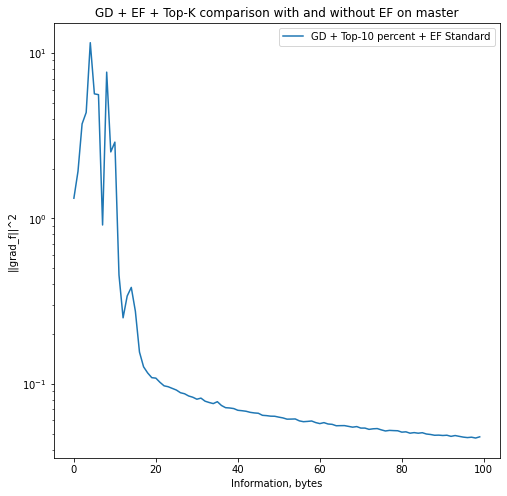

In [140]:
#GD + Top-10% + EF Standard
iter_list, points_list, differences_list, times_list, acc_list, labels_list = [], [], [], [], [], []
title = "GD + EF + Top-K comparison with and without EF on master"
n_iter = 100
compression_coeff = 0.1
k_param = int(args['d'] * compression_coeff)

def gamma_basic(k, f, grad_f, x_k, x_true, args):
    return 20/(4 * args['L'])

basic = opt.GradientOptimizer(
                                d_logloss_mushrooms, d_logloss_grad_mushrooms, x_0, criterium = '||grad_f(x_k)||', 
                                args = args, n_iter = n_iter, gamma_k = gamma_basic, n_workers = args['n_workers'],
                                rand_k_activate = False, top_k_activate=True,
                                top_k_param = k_param, rand_k_param = k_param,
                                y_lim = 1e-2, ef_activate=True, acc_k = log_acc, master_rand_k_activate = False
                                )
points_arr, differences_arr, times_arr, acc_arr = basic.descent()

iter_list.append([i for i in range(len(differences_arr))])
points_list.append(points_arr)
differences_list.append(differences_arr)
times_list.append(times_arr)
acc_list.append(acc_arr)
labels_list.append('GD + Top-10 percent + EF Standard')

opt.plot_graphs(iter_list, differences_list, x_label = "Information, bytes", lines_labels = labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2")

In [141]:
best_index = 0
final_iter_list.append(iter_list[best_index])
final_differences_list.append(differences_list[best_index])
final_labels_list.append(labels_list[best_index])

  1%|          | 1/100 [00:00<00:30,  3.25it/s]<ipython-input-83-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in true_divide
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][

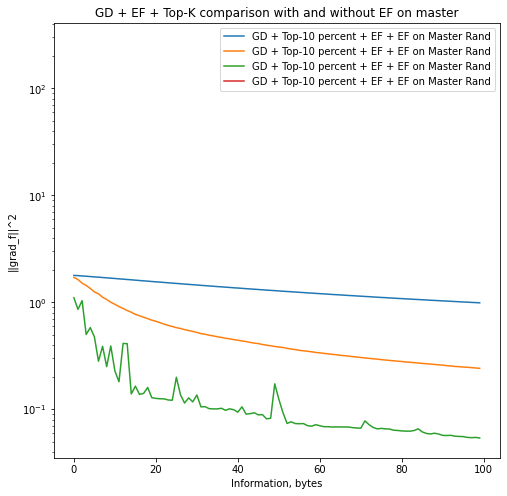

In [142]:
#GD + Top-10% + EF + EF on Master Rand-10%
iter_list, points_list, differences_list, times_list, acc_list, labels_list = [], [], [], [], [], []
title = "GD + EF + Top-K comparison with and without EF on master"
n_iter = 100
compression_coeff = 0.1
k_param = int(args['d'] * compression_coeff)

def gamma(k, f, grad_f, x_k, x_true, args):
    return args['c']/(4 * args['L'])

for args['c'] in [0.1, 1, 10, 100]:
    master_rand = opt.GradientOptimizer(
                                    d_logloss_mushrooms, d_logloss_grad_mushrooms, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = gamma, n_workers = args['n_workers'],
                                    rand_k_activate = False, top_k_activate=True,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = 1e-2, ef_activate=True, acc_k = log_acc, 
                                    server_ef_activate = True, master_rand_k_activate = True
                                    )
    points_arr, differences_arr, times_arr, acc_arr = master_rand.descent()

    iter_list.append([i for i in range(len(differences_arr))])
    points_list.append(points_arr)
    differences_list.append(differences_arr)
    times_list.append(times_arr)
    acc_list.append(acc_arr)
    labels_list.append('GD + Top-10 percent + EF + EF on Master Rand')

opt.plot_graphs(iter_list, differences_list, x_label = "Information, bytes", lines_labels = labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2")

In [143]:
best_index = 2
final_iter_list.append(iter_list[best_index])
final_differences_list.append(differences_list[best_index])
final_labels_list.append(labels_list[best_index])

  0%|          | 0/100 [00:00<?, ?it/s]

The upper limit was broken!


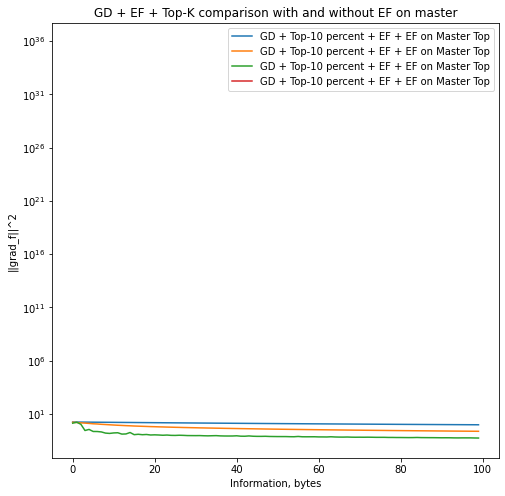

In [144]:
#GD + Top-10% + EF + EF on Master Top-10%
iter_list, points_list, differences_list, times_list, acc_list, labels_list = [], [], [], [], [], []
title = "GD + EF + Top-K comparison with and without EF on master"
n_iter = 100
compression_coeff = 0.1
k_param = int(args['d'] * compression_coeff)

def gamma(k, f, grad_f, x_k, x_true, args):
    return args['c']/(4 * args['L'])

for args['c'] in [0.1, 1, 10, 100]:
    master_rand = opt.GradientOptimizer(
                                    d_logloss_mushrooms, d_logloss_grad_mushrooms, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = gamma, n_workers = args['n_workers'],
                                    rand_k_activate = False, top_k_activate=True,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = 1e-2, ef_activate=True, acc_k = log_acc, 
                                    server_ef_activate = True, master_rand_k_activate = False
                                    )
    points_arr, differences_arr, times_arr, acc_arr = master_rand.descent()

    iter_list.append([i for i in range(len(differences_arr))])
    points_list.append(points_arr)
    differences_list.append(differences_arr)
    times_list.append(times_arr)
    acc_list.append(acc_arr)
    labels_list.append('GD + Top-10 percent + EF + EF on Master Top')

opt.plot_graphs(iter_list, differences_list, x_label = "Information, bytes", lines_labels = labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2")

In [145]:
best_index = 2
final_iter_list.append(iter_list[best_index])
final_differences_list.append(differences_list[best_index])
final_labels_list.append(labels_list[best_index])

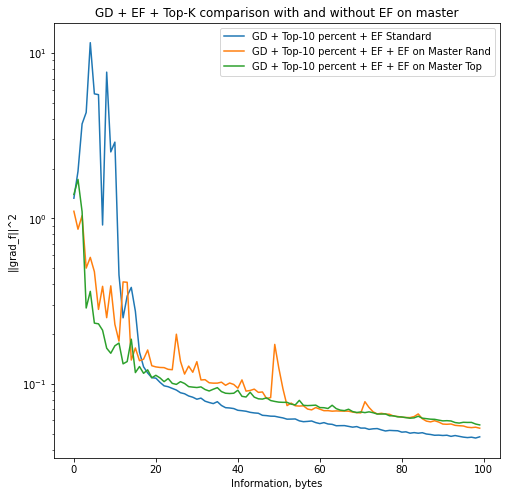

In [146]:
opt.plot_graphs(final_iter_list, final_differences_list, x_label = "Information, bytes", lines_labels = final_labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2")

Here we see that the algorithm with no EF on Master still performs the best, although the compression on Master node do not spoil the algorithm completely

### GD + Top-10% + EF21

100%|██████████| 100/100 [00:43<00:00,  2.33it/s]


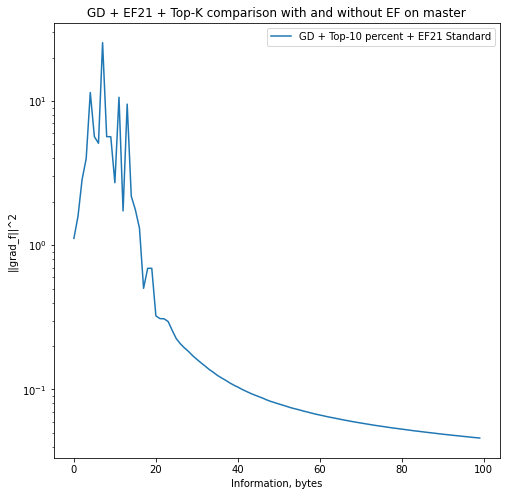

In [150]:
#GD + Top-10% + EF21 Standard
iter_list, points_list, differences_list, times_list, acc_list, labels_list = [], [], [], [], [], []
title = "GD + EF21 + Top-K comparison with and without EF on master"
n_iter = 100
compression_coeff = 0.1
k_param = int(args['d'] * compression_coeff)

def gamma_basic(k, f, grad_f, x_k, x_true, args):
    return 190/(4 * args['L'])

basic = opt.GradientOptimizer(
                                d_logloss_mushrooms, d_logloss_grad_mushrooms, x_0, criterium = '||grad_f(x_k)||', 
                                args = args, n_iter = n_iter, gamma_k = gamma_basic, n_workers = args['n_workers'],
                                rand_k_activate = False, top_k_activate=True,
                                top_k_param = k_param, rand_k_param = k_param,
                                y_lim = 1e-2, ef21_activate=True, acc_k = log_acc, master_rand_k_activate = False
                                )
points_arr, differences_arr, times_arr, acc_arr = basic.descent()

iter_list.append([i for i in range(len(differences_arr))])
points_list.append(points_arr)
differences_list.append(differences_arr)
times_list.append(times_arr)
acc_list.append(acc_arr)
labels_list.append('GD + Top-10 percent + EF21 Standard')

opt.plot_graphs(iter_list, differences_list, x_label = "Information, bytes", lines_labels = labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2")

In [148]:
best_index = 0
final_iter_list.append(iter_list[best_index])
final_differences_list.append(differences_list[best_index])
final_labels_list.append(labels_list[best_index])

100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


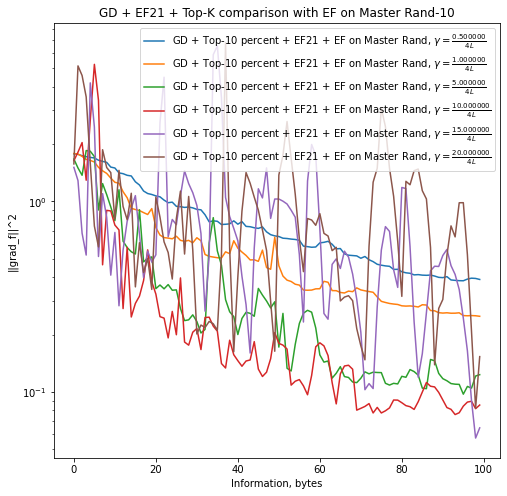

In [155]:
#GD + Top-10% + EF21 + EF on Master Rand-10%
iter_list, points_list, differences_list, times_list, acc_list, labels_list = [], [], [], [], [], []
title = "GD + EF21 + Top-K comparison with EF on Master Rand-10"
n_iter = 100
compression_coeff = 0.1
k_param = int(args['d'] * compression_coeff)

def gamma(k, f, grad_f, x_k, x_true, args):
    return args['c']/(4 * args['L'])

for args['c'] in [0.5, 1, 5, 10, 15, 20]:
    master_rand = opt.GradientOptimizer(
                                    d_logloss_mushrooms, d_logloss_grad_mushrooms, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = gamma, n_workers = args['n_workers'],
                                    rand_k_activate = False, top_k_activate=True,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = 1e-2, ef21_activate=True, acc_k = log_acc, 
                                    server_ef_activate = True, master_rand_k_activate = True
                                    )
    points_arr, differences_arr, times_arr, acc_arr = master_rand.descent()

    iter_list.append([i for i in range(len(differences_arr))])
    points_list.append(points_arr)
    differences_list.append(differences_arr)
    times_list.append(times_arr)
    acc_list.append(acc_arr)
    labels_list.append(r'GD + Top-10 percent + EF21 + EF on Master Rand, $\gamma = \frac{%f}{4L}$' % args['c'])

opt.plot_graphs(iter_list, differences_list, x_label = "Information, bytes", lines_labels = labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2")

In [156]:
best_index = 3
final_iter_list.append(iter_list[best_index])
final_differences_list.append(differences_list[best_index])
final_labels_list.append(labels_list[best_index])

 12%|█▏        | 12/100 [00:04<00:35,  2.46it/s]<ipython-input-83-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in true_divide
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list']

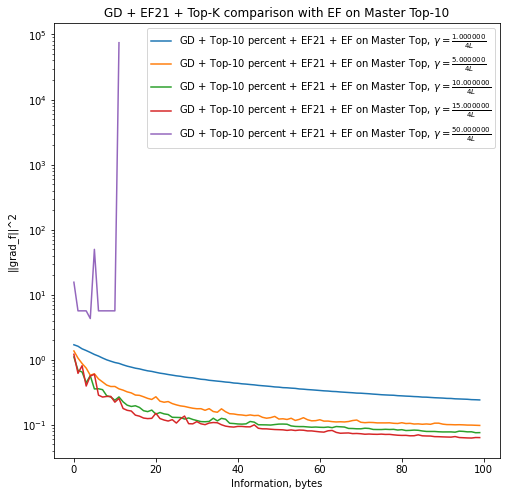

In [158]:
#GD + Top-10% + EF21 + EF on Master Top-10%
iter_list, points_list, differences_list, times_list, acc_list, labels_list = [], [], [], [], [], []
title = "GD + EF21 + Top-K comparison with EF on Master Top-10"
n_iter = 100
compression_coeff = 0.1
k_param = int(args['d'] * compression_coeff)

def gamma(k, f, grad_f, x_k, x_true, args):
    return args['c']/(4 * args['L'])

for args['c'] in [1, 5, 10, 15, 50]:
    master_rand = opt.GradientOptimizer(
                                    d_logloss_mushrooms, d_logloss_grad_mushrooms, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = gamma, n_workers = args['n_workers'],
                                    rand_k_activate = False, top_k_activate=True,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = 1e-2, ef21_activate=True, acc_k = log_acc, 
                                    server_ef_activate = True, master_rand_k_activate = False
                                    )
    points_arr, differences_arr, times_arr, acc_arr = master_rand.descent()

    iter_list.append([i for i in range(len(differences_arr))])
    points_list.append(points_arr)
    differences_list.append(differences_arr)
    times_list.append(times_arr)
    acc_list.append(acc_arr)
    labels_list.append(r'GD + Top-10 percent + EF21 + EF on Master Top, $\gamma = \frac{%f}{4L}$' % args['c'])

opt.plot_graphs(iter_list, differences_list, x_label = "Information, bytes", lines_labels = labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2")

In [159]:
best_index = 3
final_iter_list.append(iter_list[best_index])
final_differences_list.append(differences_list[best_index])
final_labels_list.append(labels_list[best_index])

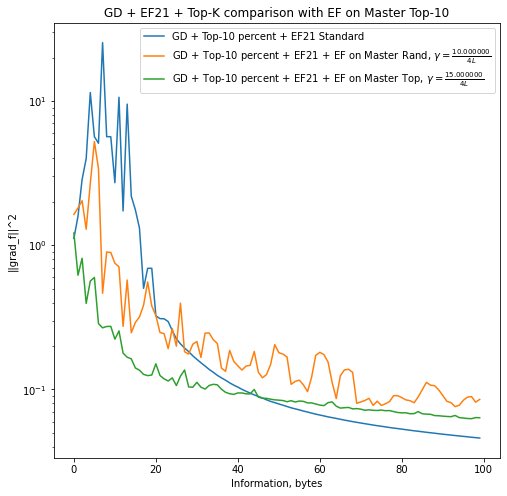

In [160]:
opt.plot_graphs(final_iter_list, final_differences_list, x_label = "Information, bytes", lines_labels = final_labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2", specific_slice=[3, 4, 5])

Here we can see that having EF on the master node with the Top-K compressor firstly helps us converge faster, although the standard version eventually outspeeds it. 

### DIANA + Top-10%

100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


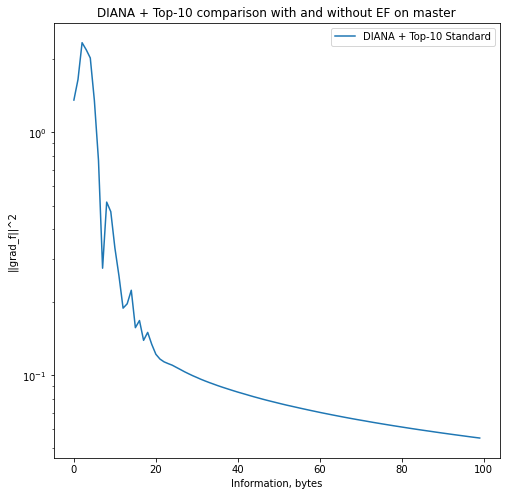

In [161]:
#DIANA + Top-10% Standard
iter_list, points_list, differences_list, times_list, acc_list, labels_list = [], [], [], [], [], []
title = "DIANA + Top-10 comparison with and without EF on master"
n_iter = 100
compression_coeff = 0.1
k_param = int(args['d'] * compression_coeff)

def gamma_basic(k, f, grad_f, x_k, x_true, args):
    return 15/(4 * args['L'])

basic = opt.GradientOptimizer(
                                d_logloss_mushrooms, d_logloss_grad_mushrooms, x_0, criterium = '||grad_f(x_k)||', 
                                args = args, n_iter = n_iter, gamma_k = gamma_basic, n_workers = args['n_workers'],
                                rand_k_activate = False, top_k_activate=True, diana_activate = True,
                                top_k_param = k_param, rand_k_param = k_param,
                                y_lim = 1e-2, acc_k = log_acc, master_rand_k_activate = False
                                )

points_arr, differences_arr, times_arr, acc_arr = basic.descent()

iter_list.append([i for i in range(len(differences_arr))])
points_list.append(points_arr)
differences_list.append(differences_arr)
times_list.append(times_arr)
acc_list.append(acc_arr)
labels_list.append('DIANA + Top-10 Standard')

opt.plot_graphs(iter_list, differences_list, x_label = "Information, bytes", lines_labels = labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2")

In [162]:
best_index = 0
final_iter_list.append(iter_list[best_index])
final_differences_list.append(differences_list[best_index])
final_labels_list.append(labels_list[best_index])

 23%|██▎       | 23/100 [00:09<00:34,  2.25it/s]<ipython-input-83-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in true_divide
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list']

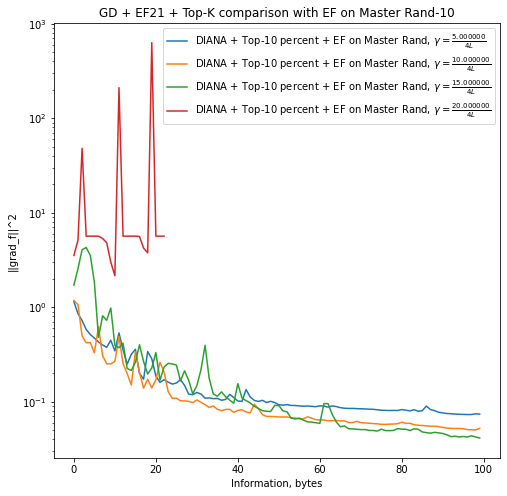

In [164]:
#DIANA + Top-10 + EF on Master Rand-10%
iter_list, points_list, differences_list, times_list, acc_list, labels_list = [], [], [], [], [], []
title = "GD + EF21 + Top-K comparison with EF on Master Rand-10"
n_iter = 100
compression_coeff = 0.1
k_param = int(args['d'] * compression_coeff)

def gamma(k, f, grad_f, x_k, x_true, args):
    return args['c']/(4 * args['L'])

for args['c'] in [5, 10, 15, 20]:
    master_rand = opt.GradientOptimizer(
                                    d_logloss_mushrooms, d_logloss_grad_mushrooms, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = gamma, n_workers = args['n_workers'],
                                    rand_k_activate = False, top_k_activate=True, diana_activate = True,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = 1e-2, acc_k = log_acc,
                                    server_ef_activate = True, master_rand_k_activate = True
                                    )
    points_arr, differences_arr, times_arr, acc_arr = master_rand.descent()

    iter_list.append([i for i in range(len(differences_arr))])
    points_list.append(points_arr)
    differences_list.append(differences_arr)
    times_list.append(times_arr)
    acc_list.append(acc_arr)
    labels_list.append(r'DIANA + Top-10 percent + EF on Master Rand, $\gamma = \frac{%f}{4L}$' % args['c'])

opt.plot_graphs(iter_list, differences_list, x_label = "Information, bytes", lines_labels = labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2")

In [165]:
best_index = 1
final_iter_list.append(iter_list[best_index])
final_differences_list.append(differences_list[best_index])
final_labels_list.append(labels_list[best_index])

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\HP\Desktop\МФТИ\S6\Optimization S2\HW\Kirill-Acharya-MIPT\my_optimization.py:317: ComplexWarning: Casting complex values to real discards the imaginary part
  compressed_grad[top_indices] = grad[top_indices]
 20%|██        | 20/100 [00:08<00:32,  2.46it/s]<ipython-input-83-05f870c057c0>:15: RuntimeWarning: overflow encountered in exp
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid value encountered in multiply
  grad_j -= np.real(args['y_train_list'][j][i] * args['X_train_list'][j][i] * np.exp(- w.dot(args['X_train_list'][j][i]) * args["y_train_list"][j][i]) / (1 + np.exp(- w.dot(args['X_train_list'][j][i]) * args['X_train_list'][j][i])))
<ipython-input-83-05f870c057c0>:15: RuntimeWarning: invalid 

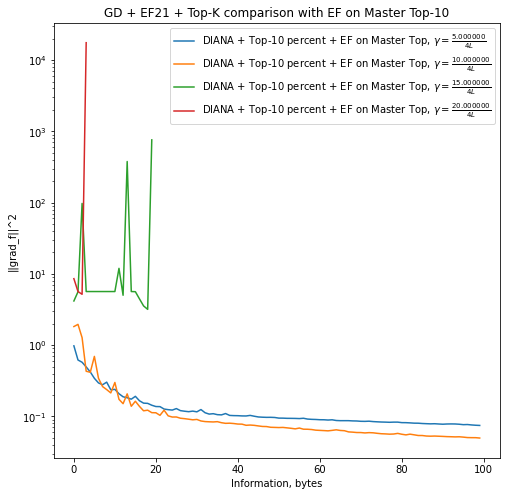

In [166]:
#DIANA + Top-10 + EF on Master Top-10%
iter_list, points_list, differences_list, times_list, acc_list, labels_list = [], [], [], [], [], []
title = "GD + EF21 + Top-K comparison with EF on Master Top-10"
n_iter = 100
compression_coeff = 0.1
k_param = int(args['d'] * compression_coeff)

def gamma(k, f, grad_f, x_k, x_true, args):
    return args['c']/(4 * args['L'])

for args['c'] in [5, 10, 15, 20]:
    master_rand = opt.GradientOptimizer(
                                    d_logloss_mushrooms, d_logloss_grad_mushrooms, x_0, criterium = '||grad_f(x_k)||', 
                                    args = args, n_iter = n_iter, gamma_k = gamma, n_workers = args['n_workers'],
                                    rand_k_activate = False, top_k_activate=True, diana_activate = True,
                                    top_k_param = k_param, rand_k_param = k_param,
                                    y_lim = 1e-2, acc_k = log_acc,
                                    server_ef_activate = True, master_rand_k_activate = False
                                    )
    points_arr, differences_arr, times_arr, acc_arr = master_rand.descent()

    iter_list.append([i for i in range(len(differences_arr))])
    points_list.append(points_arr)
    differences_list.append(differences_arr)
    times_list.append(times_arr)
    acc_list.append(acc_arr)
    labels_list.append(r'DIANA + Top-10 percent + EF on Master Top, $\gamma = \frac{%f}{4L}$' % args['c'])

opt.plot_graphs(iter_list, differences_list, x_label = "Information, bytes", lines_labels = labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2")

In [167]:
best_index = 1
final_iter_list.append(iter_list[best_index])
final_differences_list.append(differences_list[best_index])
final_labels_list.append(labels_list[best_index])

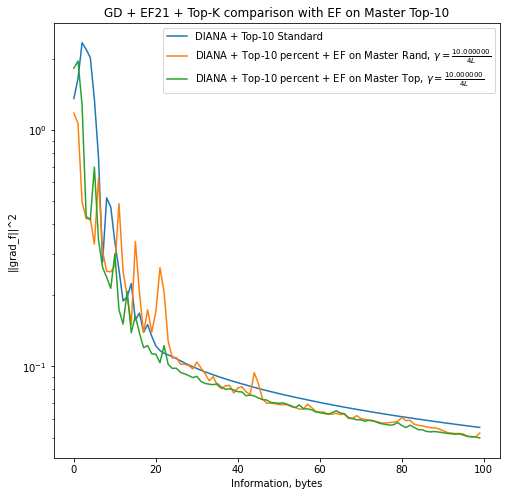

In [168]:
opt.plot_graphs(final_iter_list, final_differences_list, x_label = "Information, bytes", lines_labels = final_labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2", specific_slice=[6, 7, 8])

Here we see that the best result is when we have EF on Master Node with the TopK operator, although the difference is negligible 

Now comparing the best of the best, we have:

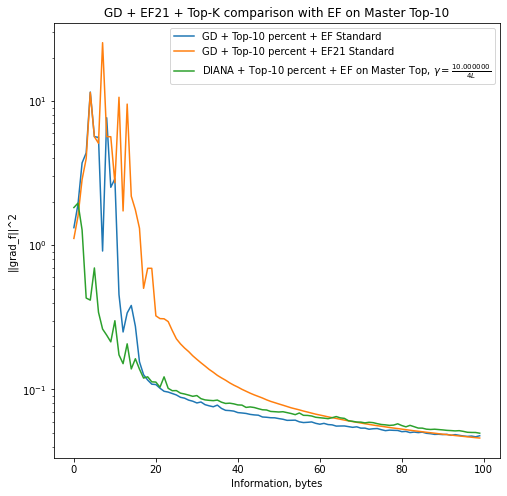

In [169]:
opt.plot_graphs(final_iter_list, final_differences_list, x_label = "Information, bytes", lines_labels = final_labels_list, title = title, 
                logscale = True, criteria_type = "||grad_f||^2", specific_slice=[0, 3, 8])

### Conclusion

Here we see that all algorithms converge almost to the same value with the same amount of iterations, but let's point out that the DIANA algothm with EF on the Master node is less volatile in convergence, so I may say that it is the best here.